In [3]:
from machinelearning.mlpipeline import MLPipelines
from machinelearning.mlexplain import MLExplainer
from dataloader.eda import DataExplorer

# csv_dir = 'data/epic_lc_ms_pos.csv'
# label = 'group'
# csv_dir = 'data/periodontal_inflammation.csv'
# label = 'Class'
csv_dir = 'data/gastric_cancer.csv'
label = 'Class'

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# dataloader
mlpipe = MLPipelines(label=label, csv_dir=csv_dir)
# mlpipe.feature_selection(method='mrmr', num_features=10, inner_method='chi2')
mlpipe.X.shape

There is no selected classifier.


(83, 149)

Normalization completed.
Normalization completed.


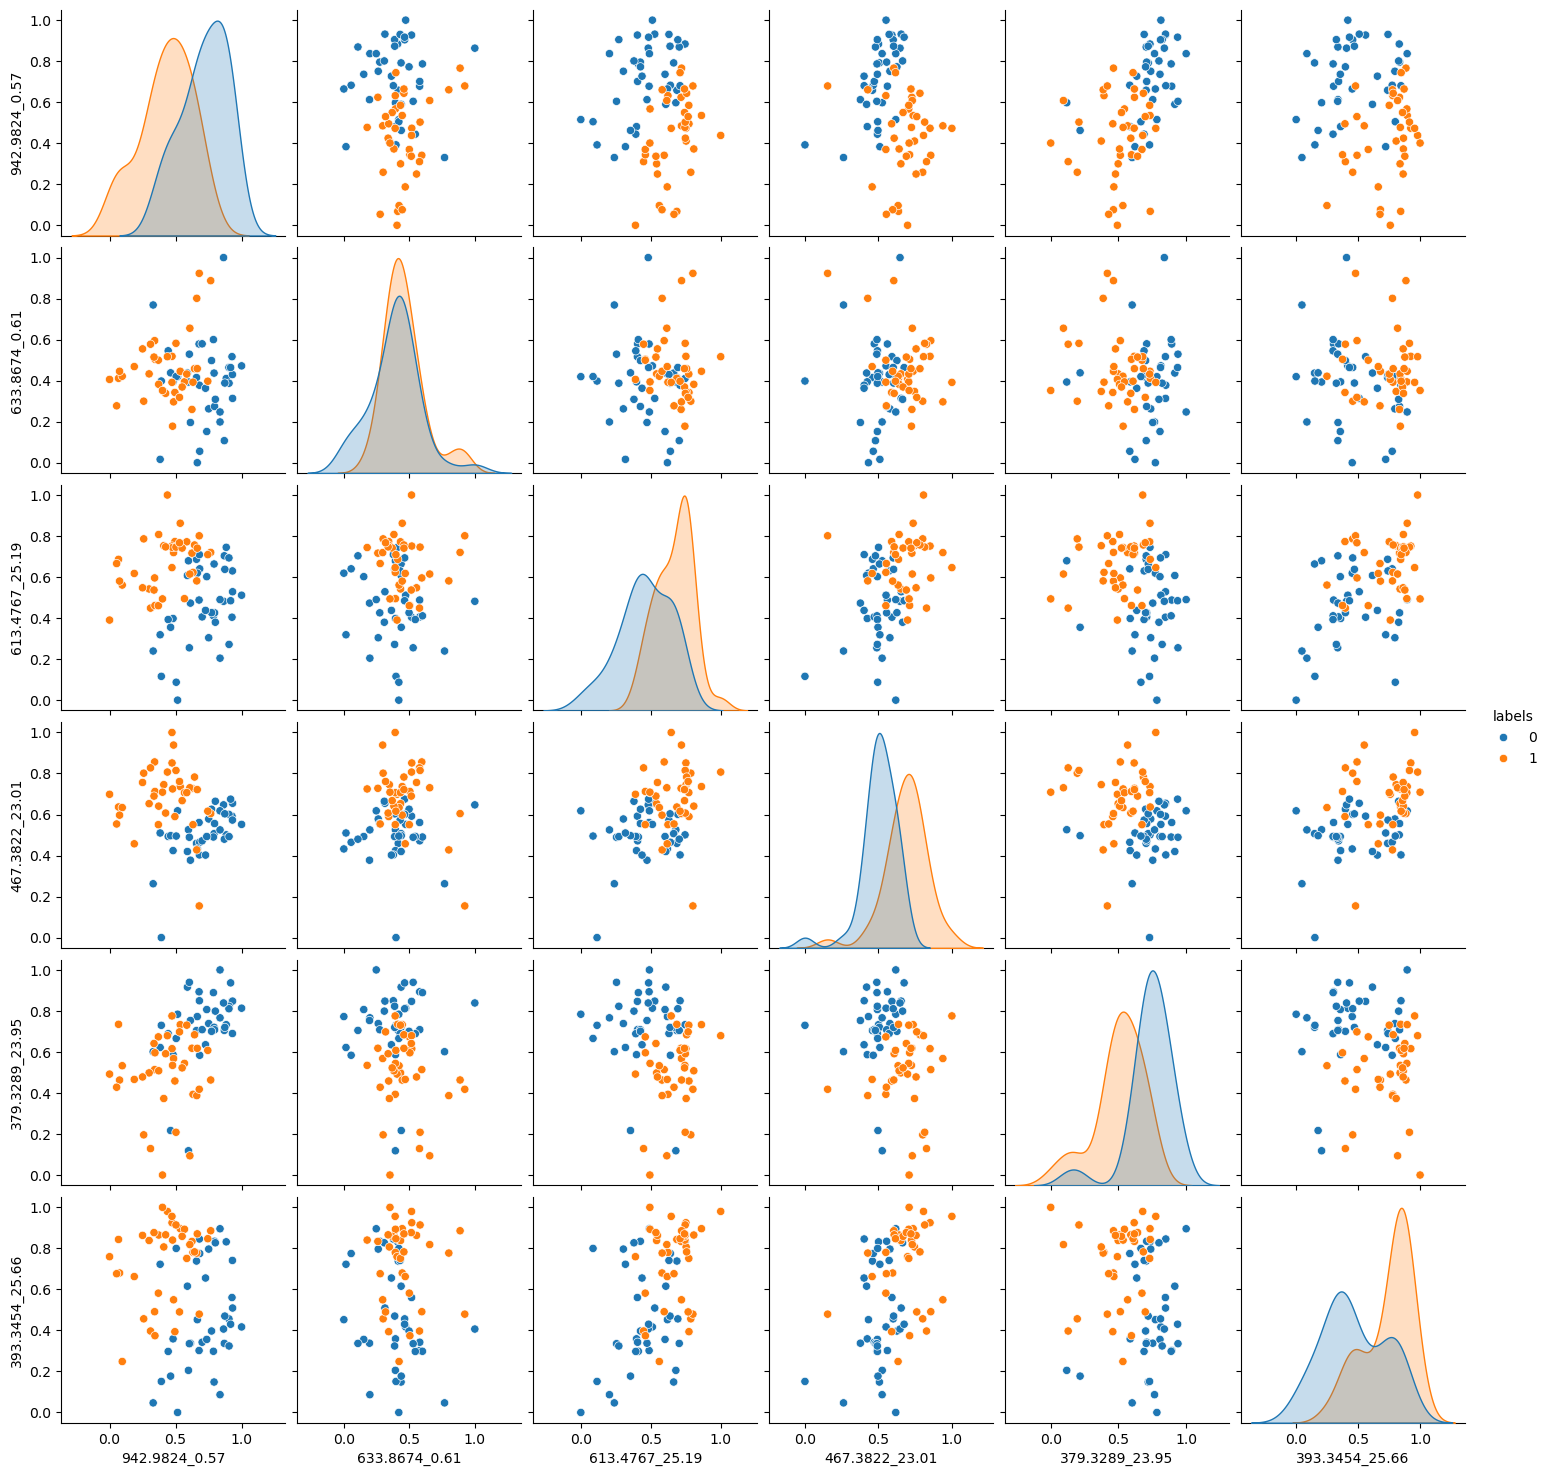

In [3]:
eda = DataExplorer(label=label, csv_dir=csv_dir)
# feat = eda.statistical_difference(show_box=False)
eda.pairplots_function(data=mlpipe.X, labels=mlpipe.y, num_of_best_features=6)#list_of_feature=feat)

In [5]:
from dataloader.dataloader import DataLoader

datal = DataLoader(label=label, csv_dir=csv_dir)
# mrmrfeatX = datal.feature_selection(method='mrmr', num_features=6, inner_method='chi2')
# mrmrfeatX


# H-NMR urinary metabolomic profiling **Paper Validation**

In [7]:
import numpy as np
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import roc_auc_score, matthews_corrcoef
from sklearn.utils import resample
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
import plotly.express as px

import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
import tqdm
import logging


level=0
optuna.logging.set_verbosity(level)
logging.getLogger("optuna").setLevel(level)

# Assuming mlpipe.X and mlpipe.y are already defined
mlpipe.X = datal.missing_values(mlpipe.X)
# mlpipe.X = mlpipe.X.fillna(0)


selected_features = ['M8','M18','M32']
X = mlpipe.X[selected_features]
# X = mlpipe.X
y = pd.DataFrame(mlpipe.y)

# Define the objective function for Optuna
def objective(trial):
#     penalty = trial.suggest_categorical('penalty', ['elasticnet'])
#     C = trial.suggest_float('C', 0.01, 1.0)
#     l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    # solver = trial.suggest_categorical('solver', ['saga'])

    alpha = trial.suggest_float('alpha', 0,1)
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    positive = trial.suggest_categorical('positive', [True, False])
    warm_start = trial.suggest_categorical('warm_start', [True, False])
    precompute = trial.suggest_categorical('precompute', [True, False])
    
    mcc_scores = []
    
    # Bootstrap resampling and Lasso fitting
    for i in range(100):  # Assuming 100 bootstrap samples
        X_resampled, y_resampled = resample(X, y, replace=True, random_state=i)
        
        # Split the resampled data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=i)
        
        # Train the Lasso model with the suggested alpha
        lasso_classifier = Lasso(alpha=alpha, selection=selection, positive=positive, warm_start=warm_start, precompute=precompute)
        # lasso_classifier = LogisticRegression(penalty=penalty, C=C, l1_ratio=l1_ratio, solver=solver)
        lasso_classifier.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = lasso_classifier.predict(X_test)

        # Convert predictions to binary using a threshold
        y_pred_binary = np.where(y_pred > 0.5, 1, 0)
        
        # Calculate the MCC
        # mcc = roc_auc_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred_binary)
        mcc_scores.append(mcc)
    
    # Return the mean score across all bootstrap samples
    return np.mean(mcc_scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)



  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score

best_params = study.best_trial.params
# model_bootstrap = LogisticRegression(**best_params)
model_bootstrap = Lasso(**best_params)

# List to store metrics for each iteration
bootstrap_scores = {
    "roc_auc": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "matthews_corrcoef": [],
    "balanced_accuracy": [],
}

# Perform bootstrap validation
for i in tqdm.tqdm(range(100), desc="Bootstrap validation"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, shuffle=True, random_state=i
    )
    model_bootstrap.fit(X_train, y_train)
    y_pred = model_bootstrap.predict(X_test)

    # Convert predictions to binary if necessary (for classification metrics)
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]

    # Calculate and store all metrics
    bootstrap_scores["roc_auc"].append(roc_auc_score(y_test, y_pred))
    bootstrap_scores["accuracy"].append(accuracy_score(y_test, y_pred_binary))
    bootstrap_scores["precision"].append(precision_score(y_test, y_pred_binary))
    bootstrap_scores["recall"].append(recall_score(y_test, y_pred_binary))
    bootstrap_scores["f1"].append(f1_score(y_test, y_pred_binary))
    bootstrap_scores["matthews_corrcoef"].append(matthews_corrcoef(y_test, y_pred_binary))
    bootstrap_scores["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred_binary))

# Convert the dictionary to a DataFrame for easy plotting and analysis
bootstrap_scores_df = pd.DataFrame(bootstrap_scores)

# Create a boxplot using Plotly
fig = px.box(bootstrap_scores["roc_auc"], y=bootstrap_scores["roc_auc"], title='Bootstrap Scores Boxplot')

# Update the layout for better aesthetics
fig.update_layout(
    yaxis_title='ROC AUC Score',
    xaxis_title='Bootstrap Samples',
    showlegend=False
)

# Show the plot
fig.show()

Bootstrap validation: 100%|██████████| 100/100 [00:03<00:00, 27.86it/s]


,Scores,mean_test_score,std_test_score,sem_test_score,params,round,ranked,roc_auc,accuracy,balanced_accuracy,recall,precision,f1,matthews_corrcoef,Estimator,Training Method,Dataset


In [22]:
bootstrap_scores_df['Scores'] = bootstrap_scores_df.matthews_corrcoef.values
bootstrap_scores_df['mean_test_score'] = bootstrap_scores_df.Scores.mean()
bootstrap_scores_df['std_test_score'] = bootstrap_scores_df.Scores.std()
bootstrap_scores_df['sem_test_score'] = bootstrap_scores_df.Scores.sem()

bootstrap_scores_df['params'] = np.NaN
bootstrap_scores_df['round'] = 'bootstrap'
bootstrap_scores_df['ranked'] = 1

bootstrap_scores_df['Estimator'] = 'Lasso'
bootstrap_scores_df['Training Method'] = 'validation_score'
bootstrap_scores_df['Dataset'] = csv_dir

bootstrap_scores_df['Features'] = str(selected_features)

bootstrap_scores_df.head()

,roc_auc,accuracy,precision,recall,f1,matthews_corrcoef,balanced_accuracy,Scores,mean_test_score,std_test_score,sem_test_score,params,round,Estimator,Training Method,Dataset,ranked,Features
0,0.897959,0.809524,0.916667,0.785714,0.846154,0.612372,0.821429,0.612372,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
1,0.867347,0.571429,0.437500,1.000000,0.608696,0.395285,0.678571,0.395285,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
2,0.851852,0.809524,0.727273,0.888889,0.800000,0.633054,0.819444,0.633054,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
3,0.954545,0.904762,0.833333,1.000000,0.909091,0.825723,0.909091,0.825723,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"
4,0.951923,0.904762,0.923077,0.923077,0.923077,0.798077,0.899038,0.798077,0.646397,0.16763,0.016763,NaN,bootstrap,Lasso,validation_score,data/gastric_cancer.csv,1,"['M8', 'M18', 'M32']"


In [23]:
init_df = pd.read_csv('paper_evaluation.csv', index_col=0)
init_df['Features'] = 'all'

In [24]:
merged_df = pd.concat([init_df, bootstrap_scores_df], ignore_index=True)
merged_df

,Scores,mean_test_score,std_test_score,sem_test_score,params,round,ranked,roc_auc,accuracy,balanced_accuracy,recall,precision,f1,matthews_corrcoef,Estimator,Training Method,Dataset,Features
0,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.944444,0.950000,0.944444,1.000000,0.916667,0.956522,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
1,0.892143,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.928571,0.950000,0.928571,1.000000,0.928571,0.962963,0.892143,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
2,0.811246,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.923077,0.900000,0.923077,0.846154,1.000000,0.916667,0.811246,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
3,0.791667,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.895833,0.900000,0.895833,0.875000,0.875000,0.875000,0.791667,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
4,0.902671,0.899512,0.086241,0.008624,NaN,bootstrap,1,0.958333,0.950000,0.958333,1.000000,0.888889,0.941176,0.902671,ElasticNet,validation_score,data/epic_lc_ms_pos.csv,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.551619,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.909091,0.761905,0.768182,0.636364,0.875000,0.736842,0.551619,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2896,0.612372,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.925926,0.809524,0.791667,0.666667,0.857143,0.750000,0.612372,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2897,0.718182,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.900000,0.857143,0.859091,0.900000,0.818182,0.857143,0.718182,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"
2898,0.633054,0.646397,0.167630,0.016763,NaN,bootstrap,1,0.953704,0.809524,0.819444,0.750000,0.900000,0.818182,0.633054,Lasso,validation_score,data/gastric_cancer.csv,"['M8', 'M18', 'M32']"


In [25]:
merged_df.to_csv('paper_evaluation.csv')

# Rest

In [7]:
# eda = DataExplorer(label=label, csv_dir=csv_dir)
# features = eda.statistical_difference(show_box=False)
mlpipe.X= mrmrfeatX

In [10]:
mod, df ,shp = mlpipe.bayesian_search(estimator_name='ElasticNet',scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, warnings_filter=True,calculate_shap=True)

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: LogisticRegression with ElasticNet penalty
Best parameters: {'penalty': 'elasticnet', 'C': 0.9972930277658288, 'solver': 'saga', 'max_iter': 524, 'n_jobs': None, 'l1_ratio': 0.22896729608698516}
Best trials score: 0.8518383643394426.


Bootstrap validation: 100%|██████████| 100/100 [00:00<00:00, 104.17it/s]


In [12]:
df.roc_auc.describe()

count    100.000000
mean       0.954578
std        0.047112
min        0.773810
25%        0.916667
50%        0.958333
75%        1.000000
max        1.000000
Name: roc_auc, dtype: float64

In [50]:
mod, df ,shp = mlpipe.bayesian_search(estimator_name='RandomForestClassifier',scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, training_method='validation_score', warnings_filter=True,calculate_shap=True)

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: RandomForestClassifier
Best parameters: {'n_estimators': 252, 'criterion': 'gini', 'max_depth': 84, 'min_samples_leaf': 2, 'bootstrap': False, 'n_jobs': 1}
Best trials score: 0.48097001501540143.


Bootstrap validation: 100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


In [38]:
df.roc_auc.describe()

count    100.000000
mean       0.844446
std        0.065631
min        0.683333
25%        0.808741
50%        0.858117
75%        0.888889
max        1.000000
Name: roc_auc, dtype: float64

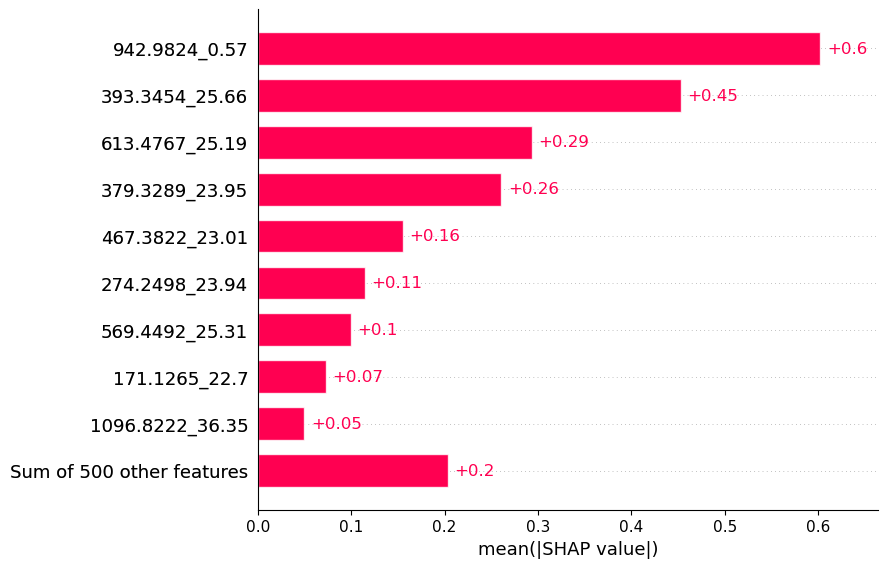

In [5]:
# mod.fit(mlpipe.X, mlpipe.y)
mlexpl = MLExplainer(mod, mlpipe.X, mlpipe.y, mlpipe.label_mapping, shap_values=shp)
# mlexpl.calculate_shap_values(explainer_type='tree')
mlexpl.plot_shap_values(plot_type="bar")

In [6]:
shap_features = ['393.3454_25.66','942.9824_0.57','379.3289_23.95',
                 '613.4767_25.19','274.2498_23.94','569.4492_25.31','467.3822_23.01'] # epic_lc_ms_pos

# shap_features = ['M25','M14','M66','M7','M52','M58','M34','M55','M63','M64','M33'] # periodontal inflammation

# shap_features = ['M138','M45']

mlpipe.X=mlpipe.X[shap_features]

In [7]:
mod, df  = mlpipe.bayesian_search(estimator_name='ElasticNet',scoring='matthews_corrcoef', evaluation='bootstrap', n_trials=100, cv=5, warnings_filter=True)#,training_method='one_sem')
# mod, df  = mlpipe.random_search(estimator_name='ElasticNet',scoring='mathews_corrcoef', evaluation='bootstrap', n_iter=150, cv=5)#,training_method='one_sem')

Normalization completed.
The bootstrap process might take some time, especially for XGBClassifier, CatBoostClassifier and RandomForestClassifier.
Estimator: LogisticRegression with ElasticNet penalty
Best parameters: {'penalty': 'elasticnet', 'C': 0.9925748746724199, 'solver': 'saga', 'max_iter': 780, 'n_jobs': None, 'l1_ratio': 0.14701134934470153}
Best trials score: 0.8279874244375905.


Bootstrap validation: 100%|██████████| 100/100 [00:01<00:00, 65.98it/s]


In [8]:
df.roc_auc.describe()

count    100.000000
mean       0.952032
std        0.048192
min        0.812500
25%        0.928571
50%        0.950000
75%        1.000000
max        1.000000
Name: roc_auc, dtype: float64

In [27]:
df.columns

Index(['Scores', 'mean_test_score', 'std_test_score', 'sem_test_score',
       'params', 'round', 'ranked', 'roc_auc', 'accuracy', 'balanced_accuracy',
       'recall', 'precision', 'f1', 'matthews_corrcoef'],
      dtype='object')

In [4]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=2,outer_splits=3,inner_splits=3,inner_selection='one_sem',search_on=['XGBClassifier','CatBoostClassifier'],parallel='freely_parallel',return_csv=True)
# df = mlpipe.nested_cv(plot='box',n_trials_ncv=10,rounds=2,outer_splits=3,inner_splits=3,inner_selection='validation_score',search_on=['ElasticNet','LogisticRegression','XGBClassifier'],return_csv=True)

Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:11:14 ETA:   0:22:28
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:29:56 ETA:   0:59:53
Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:37:29 ETA:   0:18:44
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:37:30 Time:  0:37:30


Finished with 2 round after 0.89 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:41:44 ETA:   0:20:52
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:41:45 Time:  0:41:45


Finished with 1 round after 0.90 hours.
Finished with 2 estimators


Results saved to Results/gastric_cancer_one_sem_all_features_outerloops_results.csv


In [5]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=2,outer_splits=3,inner_splits=3,inner_selection='validation_score',search_on=['XGBClassifier','CatBoostClassifier'],parallel='freely_parallel',return_csv=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:11:03 ETA:   0:22:07
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:21:51 ETA:   0:43:42
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:21:49 ETA:   0:10:54
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:21:50 Time:  0:21:50


Finished with 1 round after 0.60 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:35:36 ETA:   0:17:48
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:35:37 Time:  0:35:37


Finished with 2 round after 0.77 hours.
Finished with 2 estimators


Results saved to Results/gastric_cancer_validation_score_all_features_outerloops_results.csv


In [7]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=3,outer_splits=3,inner_splits=3,inner_selection='gso_1',search_on=['XGBClassifier'],parallel='freely_parallel',return_csv=True,show_bad_samples=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:01:22 ETA:   0:02:44
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:04:02 ETA:   0:02:01
Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:04:03 Time:  0:04:03


Finished with 3 round after 0.09 hours.


Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:02:11 ETA:   0:04:23
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:02:03 ETA:   0:04:06
Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:03:48 ETA:   0:01:54
Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:03:49 Time:  0:03:49


Finished with 1 round after 0.12 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:03:09 ETA:   0:01:34


Finished with 2 round after 0.13 hours.
Finished with 1 estimators


Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:03:10 Time:  0:03:10


Results saved to Results/gastric_cancer_gso_1_all_features_outerloops_results.csv


In [8]:
df = mlpipe.nested_cv(plot='box',n_trials_ncv=100,rounds=3,outer_splits=3,inner_splits=3,inner_selection='gso_2',search_on=['XGBClassifier'],parallel='freely_parallel',return_csv=True,show_bad_samples=True)


Your Dataset contains NaN values. Some estimators does not work with NaN values.
The median method will be used for the missing values manipulation.

All the extra metrics are valid.


Outer fold of 3 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 1 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 2 round:  0% |             | Elapsed Time: 0:00:00 ETA:  --:--:--
Outer fold of 3 round: 33% |████▎        | Elapsed Time: 0:01:01 ETA:   0:02:03
Outer fold of 2 round: 33% |████▎        | Elapsed Time: 0:01:15 ETA:   0:02:30
Outer fold of 1 round: 33% |████▎        | Elapsed Time: 0:01:43 ETA:   0:03:26
Outer fold of 3 round: 66% |████████▋    | Elapsed Time: 0:02:43 ETA:   0:01:21
Outer fold of 3 round:100% |█████████████| Elapsed Time: 0:02:44 Time:  0:02:44


Finished with 3 round after 0.06 hours.


Outer fold of 2 round: 66% |████████▋    | Elapsed Time: 0:03:27 ETA:   0:01:43
Outer fold of 2 round:100% |█████████████| Elapsed Time: 0:03:28 Time:  0:03:28


Finished with 2 round after 0.09 hours.


Outer fold of 1 round: 66% |████████▋    | Elapsed Time: 0:03:40 ETA:   0:01:50


Finished with 1 round after 0.09 hours.
Finished with 1 estimators


Outer fold of 1 round:100% |█████████████| Elapsed Time: 0:03:41 Time:  0:03:41


Results saved to Results/gastric_cancer_gso_2_all_features_outerloops_results.csv


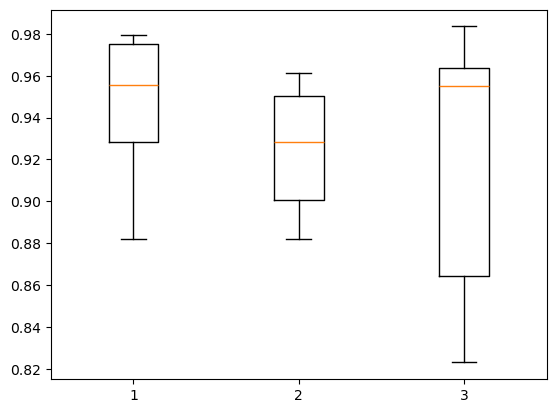

In [26]:
import matplotlib.pyplot as plt
plt.boxplot(df['roc_auc']) #df['roc_auc']
plt.show()

In [4]:
model ,df = mlpipe.bayesian_search(estimator_name='CatBoostClassifier',n_trials=15, missing_values='median')

Normalization completed.


  0%|          | 0/15 [00:00<?, ?it/s]

Estimator: CatBoostClassifier
Best parameters: {'iterations': 90, 'learning_rate': 0.036321151563099195, 'depth': 8, 'l2_leaf_reg': 0.0004417808685331767, 'border_count': 184, 'bagging_temperature': 9.13670134930253, 'random_strength': 9.861153714073298, 'leaf_estimation_method': 'Newton', 'logging_level': 'Silent', 'model_size_reg': 0.31263563587520377, 'rsm': 0.9399807945401994, 'loss_function': None}
Best matthews_corrcoef: 0.7871711623290895


In [46]:
import numpy as np
from scipy.stats import f_oneway, ttest_ind

# Example data: Mean complexity scores for different hyperparameters
important_hyperparams_1 = {
    'max_depth': [0.75],
    'n_estimators': [0.77],
    # 'learning_rate': [0.9]
}

important_hyperparams_2 = {
    'max_depth': [0.85],
    'n_estimators': [0.84],
    # 'learning_rate': [0.8]
}

less_important_hyperparams = {
    'min_samples_leaf': [0.75, 0.78],
    'min_child_weight': [0.74, 0.77],
    'gamma': [0.76, 0.79]
}

# Calculate means
important_means_1 = np.mean([np.mean(scores) for scores in important_hyperparams_1.values()])
important_means_2 = np.mean([np.mean(scores) for scores in important_hyperparams_2.values()])

# less_important_means = [np.mean(scores) for scores in less_important_hyperparams.values()]

print(f"Parameter 1: {important_means_1}, Parameter 2: {important_means_2}, Parameter Difference: {important_means_1 - important_means_2}")

Parameter 1: 0.76, Parameter 2: 0.845, Parameter Difference: -0.08499999999999996


In [13]:
samples_counts = np.zeros(10)
samples_counts[3] +=1
samples_counts

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [9]:
import numpy as np

In [14]:
for i in samples_counts:
    print(i)

0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
import optuna
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from optuna.integration import OptunaSearchCV
from sklearn.metrics import accuracy_score

# Load data
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simple model
model = SVC()

# Create a parameter distribution dictionary
param_distributions = {
    'C': optuna.distributions.FloatDistribution(0.01, 1),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
    'gamma': optuna.distributions.FloatDistribution(0.01, 1)
}

# Setup OptunaSearchCV
optuna_search = OptunaSearchCV(
    model,
    param_distributions,
    cv=3,
    return_train_score=True,
    n_trials=100,  # Number of trials to conduct
    timeout=600,   # Stop study after 600 seconds
    n_jobs=-1      # Use all available CPUs
)

# Fit the OptunaSearchCV to find the best hyperparameters
optuna_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", optuna_search.best_params_)

# Predict using the best model
predictions = optuna_search.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


[I 2024-07-05 21:51:04,057] A new study created in memory with name: no-name-f478a1a8-74bc-4773-a5dc-40e5b3723cf3
[I 2024-07-05 21:51:04,149] Trial 1 finished with value: 0.9500000000000001 and parameters: {'C': 0.5295357139760623, 'kernel': 'rbf', 'gamma': 0.36190732697212463}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,172] Trial 4 finished with value: 0.9416666666666668 and parameters: {'C': 0.20592782276453386, 'kernel': 'poly', 'gamma': 0.9612114538483573}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,178] Trial 0 finished with value: 0.7333333333333334 and parameters: {'C': 0.2902145176469904, 'kernel': 'rbf', 'gamma': 0.013237285050805424}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,184] Trial 5 finished with value: 0.325 and parameters: {'C': 0.9336066846146562, 'kernel': 'sigmoid', 'gamma': 0.7082614051302398}. Best is trial 1 with value: 0.9500000000000001.
[I 2024-07-05 21:51:04,193] Trial 6 fi

Best parameters: {'C': 0.9349413205484218, 'kernel': 'linear', 'gamma': 0.11900378926516163}
Accuracy: 1.0


In [9]:
optuna_search.trials_


[FrozenTrial(number=0, state=1, values=[0.7333333333333334], datetime_start=datetime.datetime(2024, 7, 5, 21, 51, 4, 60412), datetime_complete=datetime.datetime(2024, 7, 5, 21, 51, 4, 178575), params={'C': 0.2902145176469904, 'kernel': 'rbf', 'gamma': 0.013237285050805424}, user_attrs={'mean_fit_time': 0.017210642496744793, 'std_fit_time': 0.008458070571432984, 'mean_score_time': 0.006486733754475911, 'std_score_time': 0.004938715149793585, 'split0_test_score': 0.775, 'split1_test_score': 0.7, 'split2_test_score': 0.725, 'mean_test_score': 0.7333333333333334, 'std_test_score': 0.031180478223116204, 'split0_train_score': 0.7, 'split1_train_score': 0.75, 'split2_train_score': 0.7375, 'mean_train_score': 0.7291666666666666, 'std_train_score': 0.021245914639969964}, system_attrs={'terminator:cv_scores': [0.775, 0.7, 0.725]}, intermediate_values={}, distributions={'C': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'kernel': CategoricalDistribution(choices=('linear', 'poly', '